# TP3 Generative Adversarial Networks

Ce TP est consacré à la manipulation de réseaux génératifs exploitant le paradigme d'apprentissage "Adversarial". Ce type de réseaux comprend une partie "Générateur" et une autre "Discriminateur", chacun ayant des objectifs antagonistes. 

La première partie de ce TP illustre la capacité des GAN sur des données artificielles, sous la forme d'un mélange de gaussiennes 1D. Cette partie est fortement guidée et met en évidence la capacité des deux sous réseaux pour parvenir à approcher au mieux la distribution sous jacentes des données.

La deuxième partie nécessite un travail en autonomie. Elle consiste à étendre le réseau préalablement définie pour, cette fois, modéliser la distribution des données issues du jeu de données MNIST (les chiffres manuscrits).

Pour finir, vous pourriez vous amuser et générer des visages réalistes à partir du jeu de données CelebA.

In [0]:
#!pip install ffmpeg-python

In [0]:
import keras
import keras.backend as K
import numpy as np

Using TensorFlow backend.


## Partie 1: GANs avec des données artificielles

Dans la cellule suivante, on crée des données artificielles à partir de distributions gaussiennes. Par la suite, on modifiera le code pour obtenir des données multimodales (ie: mélange de gaussiennes).

In [0]:
batch_size = 10
nbdata = 250
data_dim = 1 # 1-dimensional data

xdata = np.random.normal(5, 0.1, (nbdata, data_dim))
#xdata1 = np.random.normal(5, 0.1, (int(nbdata/3), data_dim))
#xdata2 = np.random.normal(10, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
#xdata3 = np.random.normal(15, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
#xdata = np.concatenate((xdata1, xdata2, xdata3), axis=0) # for multimodal data
np.random.shuffle(xdata)

* Affichage de la densité de distribution correspondant à nos données

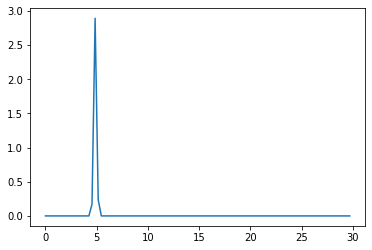

In [0]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

## Création d'un générateur python pour accéder aux données par batch

In [0]:
def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if (i*data_dim) + batch_size > nbdata: i = 0
    
    yield xdata[i:i+batch_size].reshape((batch_size, data_dim))

data_generator = get_batch()
x = next(data_generator)
print(x)

[[4.76001457]
 [5.11415989]
 [5.08339648]
 [4.9670241 ]
 [4.914756  ]
 [4.79065137]
 [5.12400147]
 [4.87144475]
 [4.97542172]
 [5.05925227]]


# Création du réseau

Ici nous créons les deux parties : "générateur" et "discriminateur", puis le modèle combiné "GAN". Réseaux très simples comprenant deux couches cachées denses avec tanh + une couche sortie. Dropout dans le discriminateur.

In [0]:
# some hyperparameters
z_dim = 5
h_dim = 10

def generator(opt,units):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(units, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(units, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(data_dim))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
units = int((h_dim+data_dim)/2)
G = generator(opt,units)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def discriminator(opt,units):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(data_dim,)))
  model.add(keras.layers.Dense(units, activation="tanh"))
  model.add(keras.layers.Dense(units, activation="tanh"))
  model.add(keras.layers.Dropout(0.4))
  
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model


units = int(h_dim/2)
D = discriminator(opt,units)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)

## Apprentissage du modèle

Boucle d'apprentissage, alterne entre le discriminateur et le GAN. Enregistre les valeurs de loss du discriminateur (lossD) et du générateur (lossG), et les prédictions du discriminateur pour des exemples positifs (Dpos) et négatifs (Dneg). Conserve l'historique dans des listes pour affichage ultérieur. On enregistre aussi des données obtenues par le générateur à chaque époque, ces données seront utilisées et animées dans une cellule suivante.

In [0]:
def train_model(n_epoch=1000):
  
  #Initialise des structures pour construire des plots
  xtab = []
  gtab = []
  lossDtab = []
  lossGtab = []
  Dpostab = []
  Dnegtab = []
  epochs_done = 0


  data_generator = get_batch()
  nb_epoch = n_epoch
  ones = np.ones((batch_size, 1))
  zeros = np.zeros((batch_size, 1))
  for epoch in range(nb_epoch):
    lossD = []
    lossG = []
    Dpos = []
    Dneg = []
    
    for batch in range(int(nbdata/batch_size)):
      # train discriminator with positive samples
      x = next(data_generator)
      """
      train_on_batch: Runs a single gradient update on a single batch of data.
      Returns: Scalar training loss
      """
      lossP = D.train_on_batch(x, ones)
      if epoch % 10 == 0:
        x = next(data_generator)
        Dpos.append(D.predict(x))

      # train discriminator with negative samples
      z = np.random.uniform(-1,1,(batch_size, z_dim))
      fakes = G.predict(z)
      lossN = D.train_on_batch(fakes, zeros)
      if epoch % 10 == 0:
        z = np.random.uniform(-1,1,(batch_size, z_dim))
        fakes = G.predict(z)
        Dneg.append(D.predict(fakes))

      # compute D's loss (for plotting)
      lossD.append((lossP + lossN) / 2.)

      # train generator with GAN
      z = np.random.uniform(-1,1,(batch_size, z_dim))
      lossG.append( GAN.train_on_batch(z, ones) )

    # Compute and store some statistics for further plotting
    if epoch % 10 == 0:
      lossD = np.mean(lossD)
      lossG = np.mean(lossG)
      Dpos = np.mean(Dpos)
      Dneg = np.mean(Dneg)

      lossDtab.append(lossD)
      lossGtab.append(lossG)
      Dpostab.append(Dpos)
      Dnegtab.append(Dneg)

      print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )

    # Sample data from generator to plot an animation of learned distribution
    z = np.random.uniform(-1,1,(10*batch_size, z_dim))
    g = G.predict(z)
    hg,_ = np.histogram(g, bins=bins, density=True)
    gtab.append(hg)
    xtab.append(hx)

    epochs_done = epochs_done + 1
   
  #On retourne les fonctions nécessaire à l'affichage pour la suite
  return  xtab,gtab,lossDtab,lossGtab,Dpostab,Dnegtab,epochs_done 

In [0]:
xtab,gtab,lossDtab,lossGtab,Dpostab,Dnegtab,epochs_done = train_model(n_epoch=1000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'










0  lossD= 0.5864988255500794  lossG= 0.70054895  Dpos= 0.6388862  Dneg= 0.5084902
10  lossD= 0.7576585245132447  lossG= 0.6162624  Dpos= 0.48839563  Dneg= 0.53972083
20  lossD= 0.6882677149772644  lossG= 0.7387764  Dpos= 0.4889505  Dneg= 0.47826037
30  lossD= 0.7061513972282409  lossG= 0.7355955  Dpos= 0.48604852  Dneg= 0.4858025
40  lossD= 0.695135862827301  lossG= 0.69474196  Dpos= 0.50148696  Dneg= 0.49862725
50  lossD= 0.6954965424537659  lossG= 0.693633  Dpos= 0.50143427  Dneg= 0.4994911
60  lossD= 0.694294114112854  lossG= 0.7005101  Dpos= 0.49856487  Dneg= 0.49763042
70  lossD= 0.694707932472229  lossG= 0.69286156  Dpos= 0.50104636  Dneg= 0.50030166
80  lossD= 0.6947144293785095  lossG= 0.6986493  Dpos= 0.49786198  Dneg= 0.4969695
90  lossD= 0.6925391674041748  lossG= 0.68641853  Dpos= 0.50533587  Dneg= 0.503497
100  lossD= 0.6945585918426513  lossG= 0.6948217  Dpos= 0.50169903  Dneg= 0.500267
110  lossD= 0.6938856172561646  lossG= 0.7038455  Dpos= 0.49643317  Dneg= 0.49

## Création et affichage des plots

**1. Evolution des prédictions du discriminateur sur les données réelles (en bleu) ou sur les données fournies par le générateur (en vert).**
On observe une convergence rapide vers 0.5, le point d'équilibre lorsque le discriminateur ne sait plus distinguer l'origine des données.

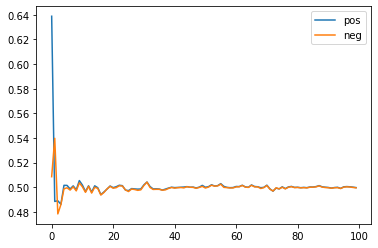

In [0]:
ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

**2. Evolution des données obtenues au cours de l'apprentissage.**
Selon le nombre d'époques, la cellule suivante prend un peu de temps pour construire un gif que nous affichons dans la foulée. Cette étape nécessite l'installation du package ffmeg-python.

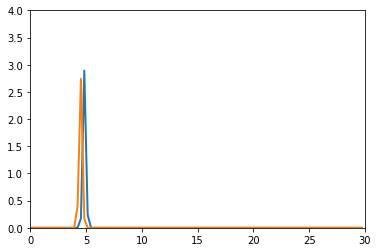

In [0]:
#!pip install ffmpeg-python

import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim

**3. Comparaison entre un batch de données original et de données issues du générateur.**

some real data: [[4.88479534]
 [5.05473764]
 [5.1307029 ]
 [4.96692034]
 [4.92199929]
 [4.82290955]
 [4.95921644]
 [5.00186844]
 [5.01331423]
 [5.10136566]]
some generated data [[5.072793 ]
 [5.0345592]
 [5.1659   ]
 [5.1722836]
 [5.078225 ]
 [5.0899286]
 [5.1295176]
 [5.158717 ]
 [5.1410146]
 [4.996318 ]]


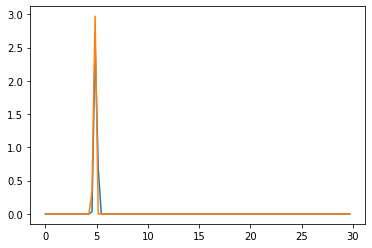

In [0]:
# get a batch of real data (for comparison)
x = next(data_generator)
print("some real data:", x)

# sample some noise then transform them with our generator
z = np.random.uniform(-1,1,(10*batch_size, z_dim))
g = G.predict(z)
print("some generated data", g[:10])

# plot distributions
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)

hg,_ = np.histogram(g, bins=bins, density=True)
plt.plot(xs,hg)

hx,_ = np.histogram(x, bins=bins, density=True)
plt.plot(xs,hx)
plt.show()

# Travail à faire

* Modifiez la première fonction de création de données pour obtenir la moitiée de données centrées autour de 5 et l'autre autour de 10. La distribution de probabilité associée à ces données est dite "multimodale" (2 modes). 

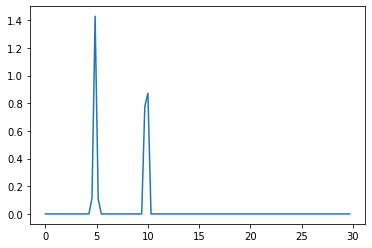

In [0]:
batch_size = 10
nbdata = 260
data_dim = 2

xdata1 = np.random.normal(5, 0.1, (int(nbdata/3), data_dim))
xdata2 = np.random.normal(10, 0.1, (int(nbdata/3), data_dim))
xdata = np.concatenate((xdata1, xdata2), axis=0)
np.random.shuffle(xdata)


#Affichage densité de distribution
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

* Réinitialisez les modèles et relancez l'apprentissage. Essayez plus d'époques si besoin. 

In [0]:
#Réinitialisation des modèles
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt,int((h_dim+data_dim)/2))
D = discriminator(opt,int(h_dim/2))
GAN = gan(opt)

In [0]:
#Boucle d'apprentissage
xtab,gtab,lossDtab,lossGtab,Dpostab,Dnegtab,epochs_done = train_model(n_epoch = 2000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0  lossD= 0.6839807285712316  lossG= 0.7439814  Dpos= 0.5161764  Dneg= 0.4793855
10  lossD= 0.1909621380842649  lossG= 1.9273664  Dpos= 0.87214583  Dneg= 0.14944422
20  lossD= 0.741533983212251  lossG= 1.0048639  Dpos= 0.56708646  Dneg= 0.36698943
30  lossD= 0.6977444749612075  lossG= 0.89165527  Dpos= 0.4923719  Dneg= 0.4140984
40  lossD= 0.6996411704100095  lossG= 0.8032341  Dpos= 0.48352098  Dneg= 0.4514777
50  lossD= 0.6955375304588904  lossG= 0.75080496  Dpos= 0.4953294  Dneg= 0.4740572
60  lossD= 0.657299110522637  lossG= 0.8056638  Dpos= 0.5058124  Dneg= 0.44357917
70  lossD= 0.698766460785499  lossG= 0.7345801  Dpos= 0.53686476  Dneg= 0.4787201
80  lossD= 0.6622456839451423  lossG= 0.7893158  Dpos= 0.54230547  Dneg= 0.45908114
90  lossD= 0.6769851812949548  lossG= 0.78260314  Dpos= 0.5232041  Dneg= 0.45799458
100  lossD= 0.6968342134585748  lossG= 0.71145386  Dpos= 0.52638596  Dneg= 0.49012956
110  lossD= 0.7016020256739396  lossG= 0.74186844  Dpos= 0.5037612  Dneg= 0.48085624


In [0]:
#Affichage des résultats
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim


Output hidden; open in https://colab.research.google.com to view.

* Augmentez les capacités du discriminateur et générateur en augmentant leur nombre de neurones dans les couches cachées.

In [0]:
#Réinitialisation des modèles
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt,int((h_dim+data_dim)*4))
D = discriminator(opt,int(h_dim*4))
GAN = gan(opt)

In [0]:
#Boucle d'apprentissage
xtab,gtab,lossDtab,lossGtab,Dpostab,Dnegtab,epochs_done = train_model(n_epoch = 1000)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0  lossD= 0.44483909010887146  lossG= 0.73023945  Dpos= 0.85702735  Dneg= 0.490974
10  lossD= 0.7438691831552066  lossG= 0.68387765  Dpos= 0.51734006  Dneg= 0.5048685
20  lossD= 0.7047635683646569  lossG= 0.7234825  Dpos= 0.50748473  Dneg= 0.48752138
30  lossD= 0.702295142870683  lossG= 0.7155469  Dpos= 0.5091911  Dneg= 0.49163893
40  lossD= 0.7041671299017392  lossG= 0.7052176  Dpos= 0.5096406  Dneg= 0.4944742
50  lossD= 0.7000418099073263  lossG= 0.71170056  Dpos= 0.5047737  Dneg= 0.49262315
60  lossD= 0.7001391672171079  lossG= 0.70397335  Dpos= 0.5027967  Dneg= 0.49368146
70  lossD= 0.7007695230153891  lossG= 0.7028383  Dpos= 0.50094175  Dneg= 0.49355316
80  lossD= 0.6986609147145197  lossG= 0.7002456  Dpos= 0.50156933  Dneg= 0.49797693
90  lossD= 0.6991210625721858  lossG= 0.7003298  Dpos= 0.49993223  Dneg= 0.49683246
100  lossD= 0.6962514221668243  lossG= 0.6939106  Dpos= 0.5015008  Dneg= 0.49843258
110  lossD= 0.6937422156333923  lossG= 0.6926013  Dpos= 0.503363  Dneg= 0.5006554

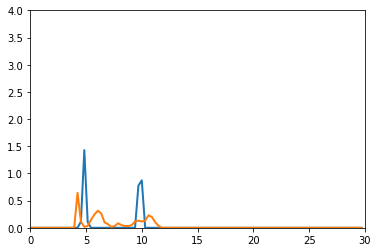

In [0]:
#Affichage des résultats
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim


* Augmentez de nouveau le nombre de modes de la distribution de données et retentez l'expérience. La difficulté de parvenir à apprendre des distributions multimodales correspond au "mode collapse" dans la littérature GAN. Une manière de contourner ce problème consiste à encourager le discriminateur à reconnaitre une diversité dans un batch d'exemples. Plusieurs approches ont été proposées dans ce sens, dont "batch discrimination" et "standard deviation discrimination" (à voir dans la littérature).

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0  lossD= 0.593217214345932  lossG= 0.6745959  Dpos= 0.70182216  Dneg= 0.50894505
10  lossD= 0.7795808053016663  lossG= 0.6859763  Dpos= 0.4767188  Dneg= 0.49752626
20  lossD= 0.654186282157898  lossG= 0.7589508  Dpos= 0.5548721  Dneg= 0.4744509
30  lossD= 0.6867815589904785  lossG= 0.75397974  Dpos= 0.52771616  Dneg= 0.4678718
40  lossD= 0.7046425008773803  lossG= 0.7513098  Dpos= 0.5037369  Dneg= 0.4719964
50  lossD= 0.6928685688972473  lossG= 0.71556044  Dpos= 0.52149796  Dneg= 0.48899484
60  lossD= 0.6960534262657165  lossG= 0.72427475  Dpos= 0.51260877  Dneg= 0.48543108
70  lossD= 0.7012999153137207  lossG= 0.7229054  Dpos= 0.50621617  Dneg= 0.48500627
80  lossD= 0.7003799676895142  lossG= 0.7101798  Dpos= 0.5014088  Dneg= 0.48990852
90  lossD= 0.7013793420791626  lossG= 0.70778215  Dpos= 0.4996971  Dneg= 0.4940108
100  lossD= 0.6995467948913574  lossG= 0.70476615  Dpos= 0.5016094  Dneg= 0.49598992
110  lossD= 0.7030512428283692  lossG= 0.7122133  Dpos= 0.4955796  Dneg= 0.49163464

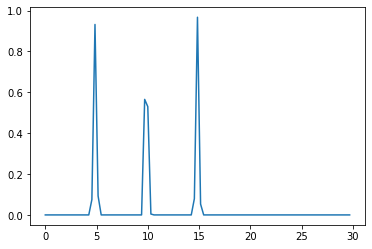

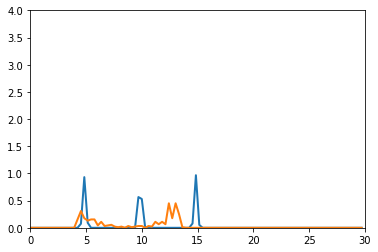

In [0]:
batch_size = 10
nbdata = 250
data_dim = 3

xdata1 = np.random.normal(5, 0.1, (int(nbdata/3), data_dim))
xdata2 = np.random.normal(10, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
xdata3 = np.random.normal(15, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
xdata = np.concatenate((xdata1, xdata2, xdata3), axis=0) # for multimodal data
np.random.shuffle(xdata)

#Affichage densité de distribution
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

#Réinitialisation des modèles
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt,int((h_dim+data_dim)*4))
D = discriminator(opt,int(h_dim*4))
GAN = gan(opt)

#Boucle d'apprentissage
xtab,gtab,lossDtab,lossGtab,Dpostab,Dnegtab,epochs_done = train_model(n_epoch = 1500)

#Affichage des résultats
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim


 # **Partie 2: GANs sur MNIST**

Cette partie se déroule en totale autonomie.. Une fois bien compris la partie précédente, proposez un réseau antagoniste pour générer des chiffres manuscrits (et/ou des visages pour les très motivés). 

Selon la nature et la structure des données, les réseaux "générateur" et "discriminateur" pourront exploiter des couches convolutionnelles, batch_discrimination ou dropout. Attention les couches Batch Discrimination et Dropout se comportent différemment lorsqu'elle sont utilisées en phase d'apprentissage ou d'inférence. Or, le discriminateur utilisé par le modèle combiné "GAN" est en mode "inférence" étant donné qu'il est configuré pour ne pas apprendre. Dans ce cas, avec Keras il est nécessaire de préciser `training=True` à l'initialisation de ces couches.

Pour MNIST, nous considéront que le générateur prend en entrée un vecteur aléatoire de dimension 10, puis augmentera la taille des représentation jusqu'aux images ciblées (ie 28x28 pour MNIST) par l'emploi successifs de :
- couches Denses de tailles adéquates (ie: 10 - 100 - 400 - 784), en augmentant le nombre de neurones, puis en utilisant la couche Reshape avant la sortie.
- couches Conv2D couplées avec des couches UpSampling ; ou Conv2DTranspose. Toujours en augmentant progressivement la taille des représentation.

# **Il faut relancer le notebook à partir d'ici, la suite est en tensorflow2**

In [0]:
try:
    %tensorflow_version 2.x
    import tensorflow as tf
    from tensorflow.keras import layers

    import time
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import animation, rc
    
    # for image handling
    from IPython import display

except Exception:
    print('Tensorflow version 2 not available')

### Récupération du dataset

In [0]:
def data_mnist(buffer_size, batch_size):
    # download train dataset
    (train_x, _), (_, _) = tf.keras.datasets.mnist.load_data()

    # reshape to NN format and normalize the images to [-1, 1]
    train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
    train_x = (train_x - 127.5) / 127.5

    # batch and shuffle the data according to tensorflow recommandations
    return tf.data.Dataset.from_tensor_slices(train_x).shuffle(buffer_size).batch(batch_size)

## Implémentation du générateur

In [0]:
def generator_mnist():
    model = tf.keras.Sequential([
        # block 1
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # block 2 : reshape to 7*7 image
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same',
                               use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # blokck 3 : upsample to 14*14 image
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                               use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # block 4 : upsample to 28*28 image
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                               use_bias=False, activation='tanh')
    ])
    return model

#### Notre générateur non entrainé doit juste transformer la "forme" du bruit, d'un vecteur (100) à une image en noir et blanc de 28 par 28

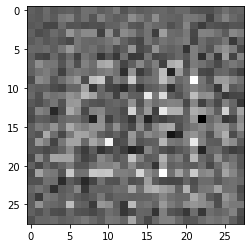

In [0]:
generator = generator_mnist()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Implémentation du discriminateur

In [0]:
def discriminator_mnist():
    model = tf.keras.Sequential([
        # first block
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                      input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # second block
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        # prediction block
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [0]:
discriminator = discriminator_mnist()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00057087]], shape=(1, 1), dtype=float32)


## Implémentation du GAN

### Définition de la loss

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def gan_loss(logits, is_real=True):
    """
    Computes standard gan loss between logits and labels
    """
    labels = tf.ones_like(logits) if is_real else tf.zeros_like(logits)
    return cross_entropy(labels, logits)

### Implémentation du GAN comme un modèle keras

In [0]:
class GAN(tf.keras.Model):
    """
    A basic GAN class based on tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

    def generate(self, noise, training):
        return self.G(noise, training)

    def discriminate(self, x, training):
        return self.D(x, training)

    # `tf.function` annotation causes the function to be "compiled".
    @tf.function
    def train(self, real_x):
        """
        Passes through the network, computes loss, compute gradients then update
        the network.
        """
        # generating noise from a uniform distribution
        # `100` is the input data dimension
        noise = tf.random.normal([real_x.shape[0], 100])

        with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            # run noise through generator
            fake_x = self.generate(noise, training=True)

            # discriminate real_x and fake_x
            real_output = self.discriminate(real_x, training=True)
            fake_output = self.discriminate(fake_x, training=True)

            # compute real and fake losses for discriminator
            D_real_loss = gan_loss(logits=real_output, is_real=True)
            D_fake_loss = gan_loss(logits=fake_output, is_real=False)
            D_loss = D_fake_loss + D_real_loss

            # compute generator loss
            G_loss = gan_loss(logits=fake_output, is_real=True)
        
        # compute gradients
        G_gradients = G_tape.gradient(G_loss, self.G.trainable_variables)
        D_gradients = D_tape.gradient(D_loss, self.D.trainable_variables)

        # update network weights
        self.G_optimizer.apply_gradients(
            zip(G_gradients, self.G.trainable_variables)
        )
        self.D_optimizer.apply_gradients(
            zip(D_gradients, self.D.trainable_variables)
        )

### En avant pour l'apprentissage !

epoch 49 | time 6.001938581466675


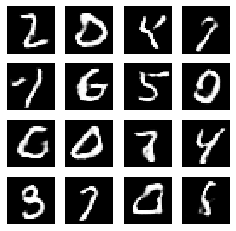

In [0]:
# hyperparameters
N_SAMPLES = 60_000
BATCH_SIZE = 256
N_EPOCHS = 50
OPTIMIZER = tf.keras.optimizers.Adam(1e-4)

# define our gan
GAN_mnist = GAN(D=discriminator, G=generator,
                D_optimizer=OPTIMIZER, G_optimizer=OPTIMIZER)

# to visualize progress with same examples
n_examples = 16
seed = tf.random.normal([n_examples, 100])

# let's do it
DATASET = data_mnist(N_SAMPLES, BATCH_SIZE)
for epoch in range(N_EPOCHS):
    start = time.time()

    # one pass through all dataset
    for batch_x in DATASET:
        GAN_mnist.train(batch_x)

    # display epoch information
    display.clear_output(wait=True)
    print(f"epoch {epoch} | time {time.time() - start}")

    # produce test images
    predictions = GAN_mnist.generate(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.axis('off')
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.show()